In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
from alpha_vantage.foreignexchange import ForeignExchange 

In [2]:
api_key = "968U93YONJTBSCFS"   #My Api Key

In [3]:
# Initialize the ForeignExchange class
fx = ForeignExchange(key= "api_key", output_format="pandas")

In [4]:
# Get the daily exchange rates
data, meta_data = fx.get_currency_exchange_daily(from_symbol="USD", to_symbol="KES", outputsize="full")

In [5]:
# Renaming columns
data.rename(columns={
    "1. open": "Open",
    "2. high": "High",
    "3. low": "Low",
    "4. close": "Close"
}, inplace=True)

In [6]:
data = data.sort_index()

In [7]:
data = data.loc['2023':]

In [8]:
data.head()

,Open,High,Low,Close
date,,,,
2023-01-01,122.40,122.41,121.65612,122.50
2023-01-02,122.41,123.40,122.05000,122.41
2023-01-03,122.55,122.57,122.05000,122.55
2023-01-04,122.55,122.66,122.30000,123.40
2023-01-05,122.60,122.66,122.22898,122.60


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 425 entries, 2023-01-01 to 2024-08-16
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    425 non-null    float64
 1   High    425 non-null    float64
 2   Low     425 non-null    float64
 3   Close   425 non-null    float64
dtypes: float64(4)
memory usage: 16.6 KB


In [10]:
# Summary statistics
data.describe()

,Open,High,Low,Close
count,425.000000,425.000000,425.000000,425.000000
mean,138.277807,138.870458,137.382683,138.309145
std,10.640214,10.651843,12.025949,10.658739
min,122.400000,122.410000,16.150000,122.050610
25%,129.000000,130.000000,128.670000,129.000000
50%,136.800000,137.300000,135.899990,136.800000
75%,146.300000,146.950000,145.350010,146.300000
max,162.990000,163.210010,161.570010,163.000000


In [11]:
data = data["Close"]
data = pd.DataFrame(data=data)

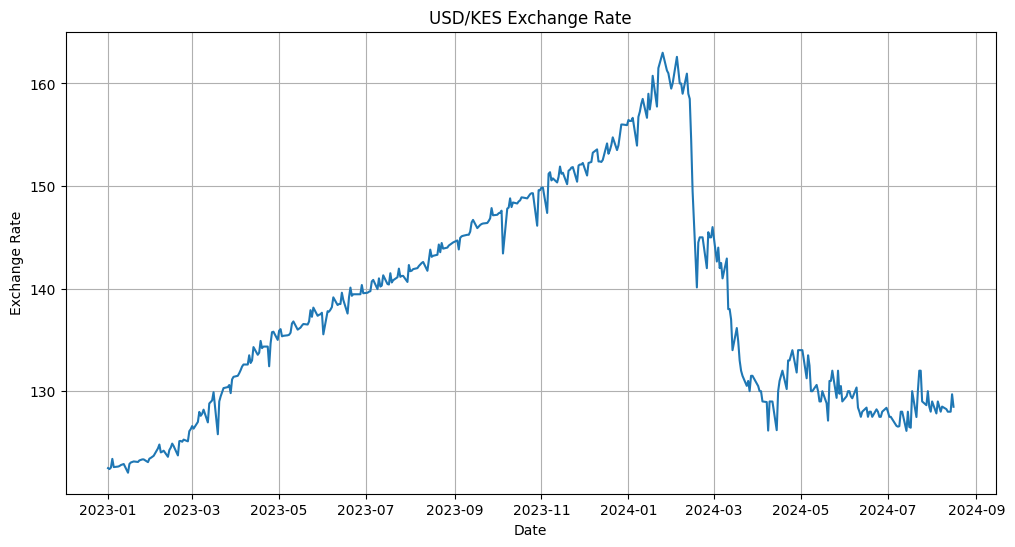

In [12]:
# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(data['Close'])
plt.title('USD/KES Exchange Rate')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.grid()
plt.show()

In [13]:
# Resample the data to include all the days
daily_data = data.resample('D').last()

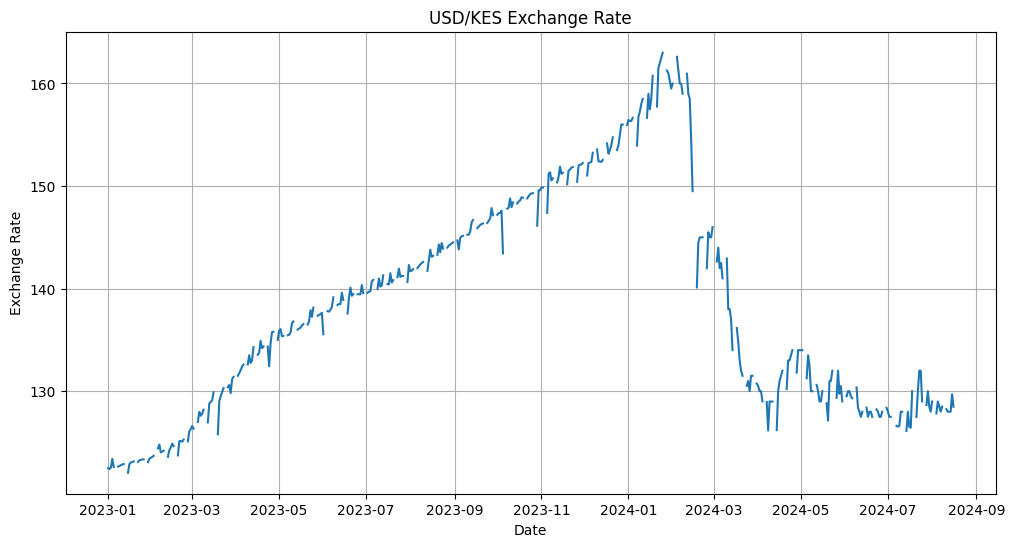

In [14]:
# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(daily_data['Close'])
plt.title('USD/KES Exchange Rate')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.grid()
plt.show()

In [15]:
# interpolate the data to include weekends
filled_data = daily_data.interpolate(method='linear')

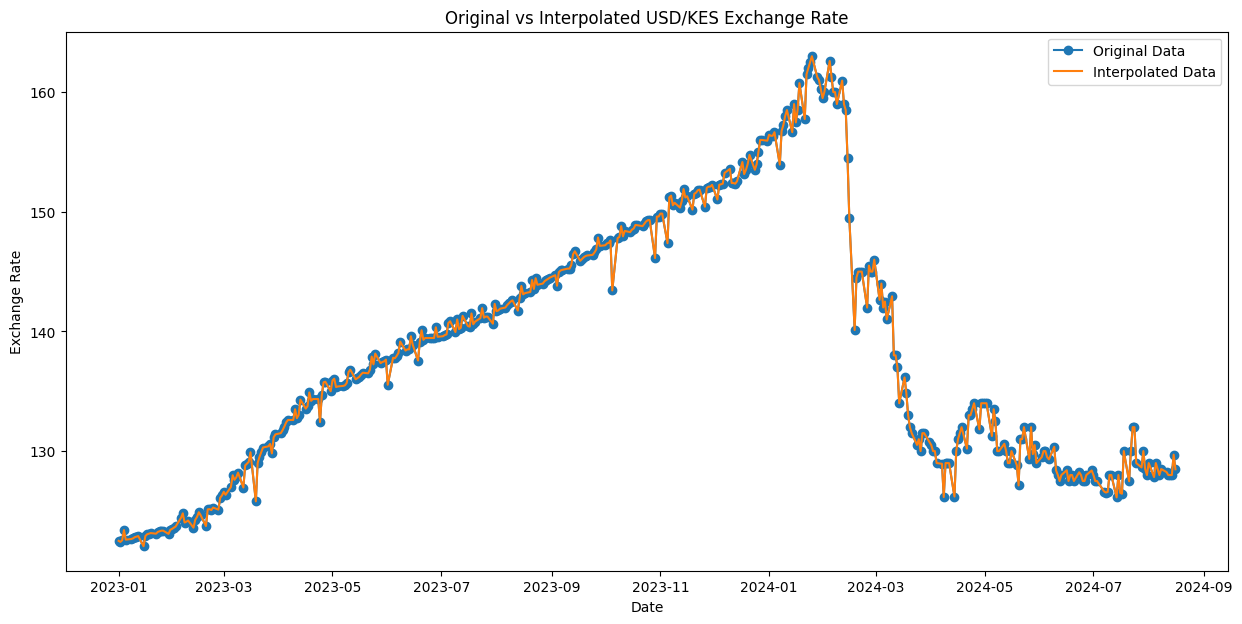

In [16]:
# Plot original vs filled data
plt.figure(figsize=(15, 7))
plt.plot(data.index, data['Close'], label='Original Data', marker='o')
plt.plot(filled_data.index, filled_data['Close'], label='Interpolated Data')
plt.title('Original vs Interpolated USD/KES Exchange Rate')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

# Stationarity Check

In [17]:
from statsmodels.tsa.stattools import adfuller

# Perform the Augmented Dickey-Fuller test
adf_test = adfuller(filled_data['Close'])
print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')

# If p-value > 0.05, the series is non-stationary
if adf_test[1] > 0.05:
    print("The series is non-stationary, differencing is required.")
else:
    print("The series is stationary.")

ADF Statistic: -1.3977104390739634
p-value: 0.5833732692568983
The series is non-stationary, differencing is required.


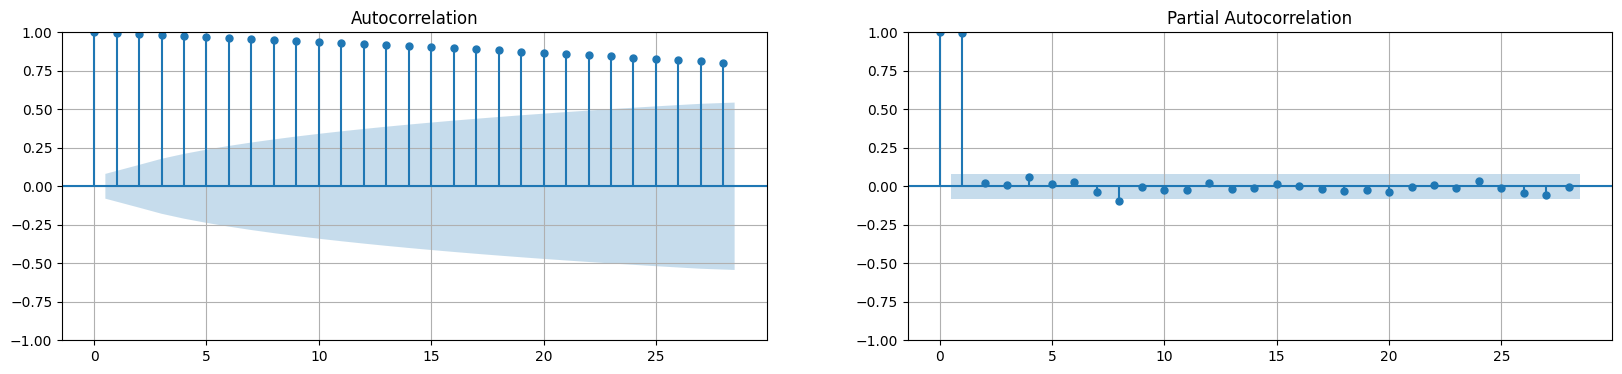

In [18]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(20, 4))
plot_acf(filled_data, ax=axes[0])
axes[0].grid(True)
plot_pacf(filled_data, ax=axes[1])
axes[1].grid(True)
plt.show()

ACF is not deminishing

#  Prepare data for modeling

## Split the filled data into train and test sets

In [19]:
# Split the filled data into train and test sets
train_size = int(len(filled_data) * 0.80)
train, test = filled_data[:train_size], filled_data[train_size:]

In [20]:
print("Train: ",train.shape)
print("Test : ",test.shape)

Train:  (475, 1)
Test :  (119, 1)


In [21]:
# from pmdarima.arima import auto_arima
# model_auto = auto_arima(filled_data[1:])
# model_auto

In [22]:
# model_auto.summary()

## Decomposition

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [24]:
add_decomp = seasonal_decompose(train, model="additive")

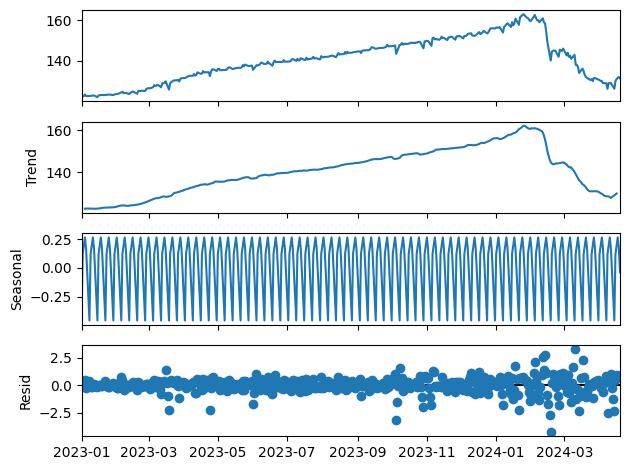

In [25]:
add_decomp.plot()
plt.show()

- there is a trend in the data
- the data is also seasonal
- there is also White noise

## Augmented Dickey-Fuller (ADF) test 

In [26]:
import statsmodels.tsa.stattools as sts
adf_results = sts.adfuller(train)
#adf_results

In [27]:
adf_statistic = adf_results[0]
p_value = adf_results[1]
usedlag = adf_results[2]
nobs = adf_results[3]
critical_values = adf_results[4]
icbest = adf_results[5]

In [28]:
print('ADF Statistic:', adf_statistic)
print('p-value:', p_value)
print('Number of Lags Used:', usedlag)
print('Number of Observations Used:', nobs)
print('Critical Values:')
for key, value in critical_values.items():
    print(f'\t{key}: {value}')

ADF Statistic: -1.5772738006431186
p-value: 0.49499875437743945
Number of Lags Used: 7
Number of Observations Used: 467
Critical Values:
	1%: -3.4444305322234365
	5%: -2.8677488864580885
	10%: -2.5700770984781443


Based on the ADF test results, 

- Test statistic: The ADF statistic is higher (less negative) than all the critical values.
- p-value: The p-value is greater than the common significance levels (0.01, 0.05, and 0.10).
- Stationarity: Given that the test statistic is higher than the critical values and the p-value is greater than 0.05, we fail to reject the null hypothesis of a unit root. This suggests that the time series is likely non-stationary.
- Critical values: Since the test statistic is less negative than all these critical values, it supporting the conclusion of non-stationarity.
- Sample size: Is a relatively large sample size, lending reliability to the results.
- Lag selection: 28 lags were used in the test, which helps account for potential autocorrelation in the residuals.

In conclusion, this time series appears to be non-stationary based on the ADF test results. Further differencing or transformation is necessary to achieve stationarity before proceeding with certain time series analyses or models.

# Modeling


## Differencing the Series

In [29]:
diff = train.diff().dropna()

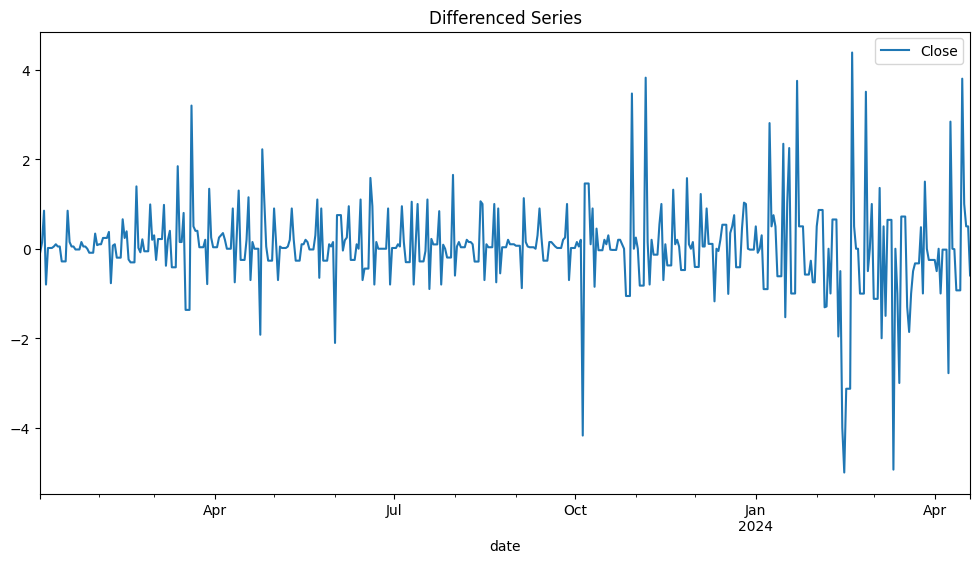

In [30]:
# Plot the differenced series
diff.plot(figsize=(12, 6))
plt.title('Differenced Series')
plt.show()

In [32]:
# Perform the ADF test on the differenced series
adf_result_diff = adfuller(diff)
print('ADF Statistic after Differencing:', adf_result_diff[0])
print('p-value after Differencing:', adf_result_diff[1])
print('Number of Lags Used:', adf_result_diff[2])
print('Number of Observations Used:', adf_result_diff[3])
print('Critical Values after Differencing:', adf_result_diff[4])

ADF Statistic after Differencing: -6.969123519846215
p-value after Differencing: 8.757246075198372e-10
Number of Lags Used: 6
Number of Observations Used: 467
Critical Values after Differencing: {'1%': -3.4444305322234365, '5%': -2.8677488864580885, '10%': -2.5700770984781443}


Deductions
- Since the p-value is now lower than 0.005 and the ADF statistic is more negative than the critical values indicate that the time series has become stationary after differencing. 
- Applying one difference (d=1) was sufficient to make the series stationary.

## Proceeding to identify the appropriate values for p and q by analyzing the ACF and PACF plots.

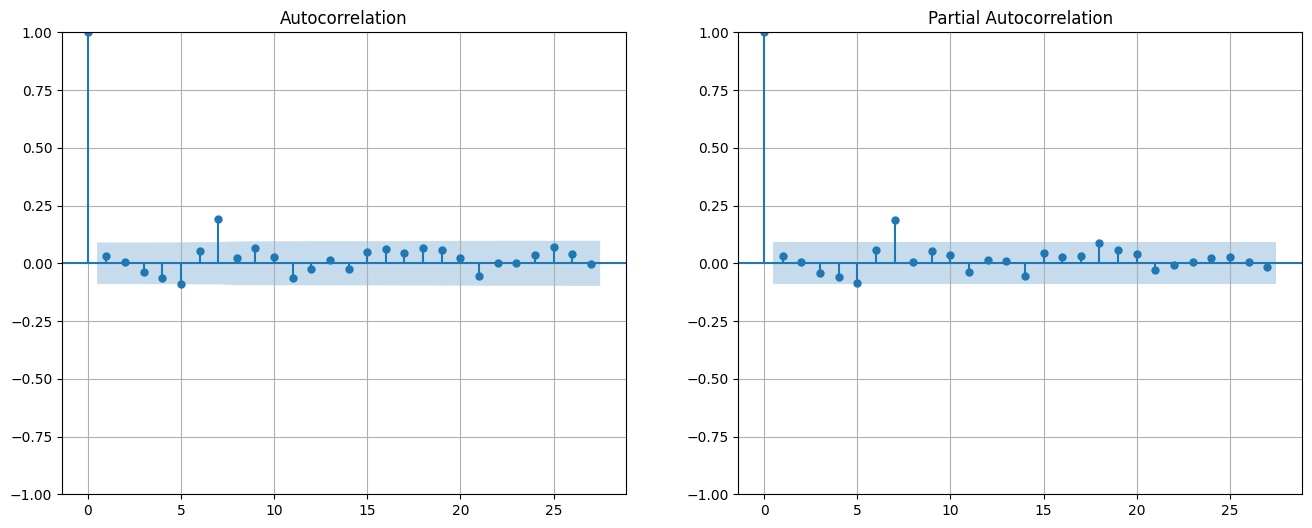

In [33]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(diff, ax=axes[0])
axes[0].grid(True)
plot_pacf(diff, ax=axes[1])
axes[1].grid(True)
plt.show()

- p = 1
- d = 1
- q = 1
- m = 7

# Model selection

# Method 1

## 1. ARIMA

In [34]:
from statsmodels.tsa.arima.model import ARIMA

# Replace p, d, q with the values identified from ACF and PACF
model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit()

In [35]:
# Summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  475
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -647.690
Date:                Sat, 17 Aug 2024   AIC                           1301.381
Time:                        12:19:50   BIC                           1313.864
Sample:                    01-01-2023   HQIC                          1306.290
                         - 04-19-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0720      1.112      0.065      0.948      -2.107       2.251
ma.L1         -0.0399      1.133     -0.035      0.972      -2.260       2.181
sigma2         0.9003      0.027     33.288      0.0

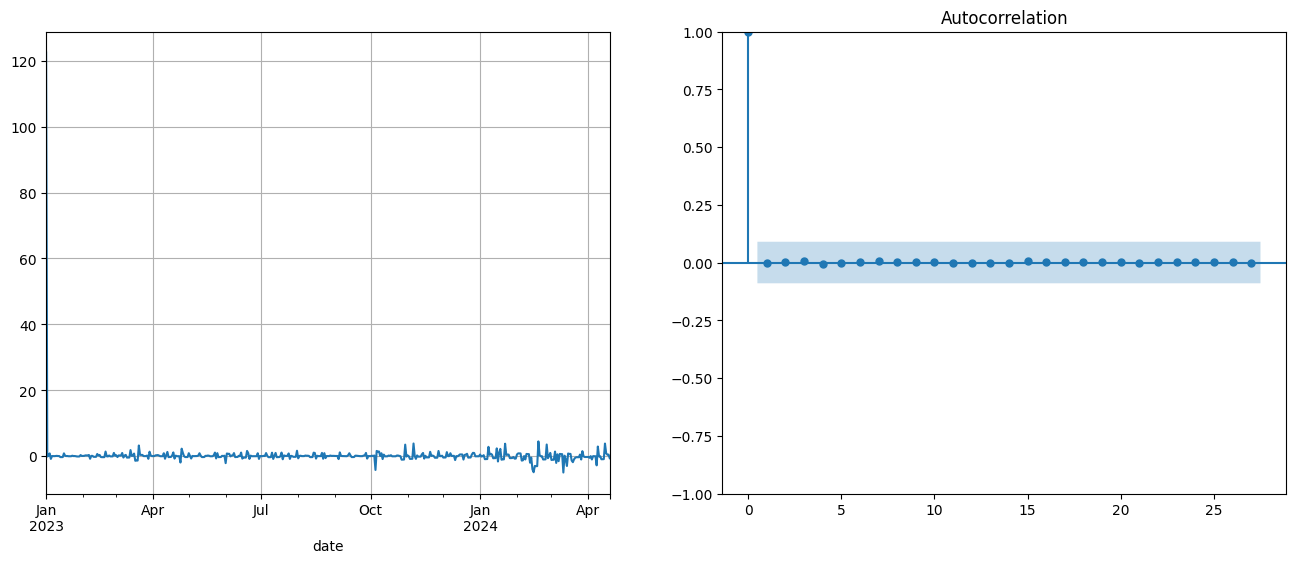

In [36]:
residuals = model_fit.resid

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
# Plot residuals
residuals.plot(ax=axes[0])
axes[0].grid(True)
# Plot ACF of residuals
plot_acf(residuals, ax=axes[1])

plt.show()

In [37]:
predictions = model_fit.predict(start=len(train), end=len(train)+ len(test)-1, dynamic=True)

In [38]:
predictions

2024-04-20    131.384837
2024-04-21    131.383505
2024-04-22    131.383409
2024-04-23    131.383402
2024-04-24    131.383402
                 ...    
2024-08-12    131.383402
2024-08-13    131.383402
2024-08-14    131.383402
2024-08-15    131.383402
2024-08-16    131.383402
Freq: D, Name: predicted_mean, Length: 119, dtype: float64

In [39]:
from sklearn.metrics import mean_squared_error

# Calculate Mean Squared Error
mse = mean_squared_error(test, predictions)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 7.956697288358672


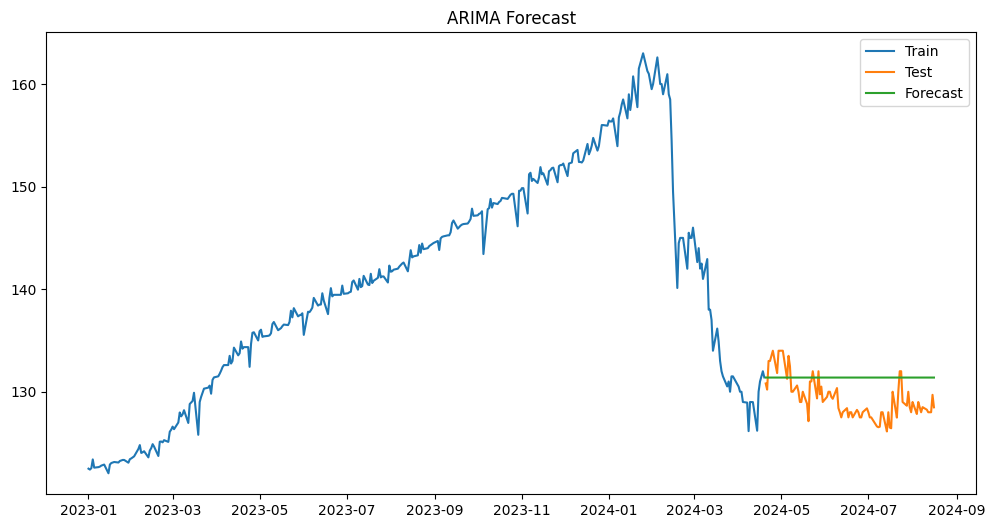

In [40]:
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, predictions, label='Forecast')
plt.title('ARIMA Forecast')
plt.legend()
plt.show()

## 2. SARIMA


In [41]:
p, d, q = 2, 1, 1

In [42]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model_s = SARIMAX(train, order=(p, d, q), seasonal_order=(p, d, q, 7))  
fitted = model_s.fit() 


C:\Users\Dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal movin

In [43]:
print(fitted.summary())

                                     SARIMAX Results                                     
Dep. Variable:                             Close   No. Observations:                  475
Model:             SARIMAX(2, 1, 1)x(2, 1, 1, 7)   Log Likelihood                -625.522
Date:                           Sat, 17 Aug 2024   AIC                           1265.043
Time:                                   12:21:40   BIC                           1294.068
Sample:                               01-01-2023   HQIC                          1276.465
                                    - 04-19-2024                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9437      0.029    -33.092      0.000      -1.000      -0.888
ar.L2          0.0547      0.027      2.056

In [44]:
from sklearn.metrics import mean_squared_error

# Get the predicted values
predictions2 = fitted.predict(start=len(train), end=len(train)+ len(test)-1, dynamic=True)


In [45]:
# Calculate Mean Squared Error
mse = mean_squared_error(test, predictions2)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 17.02671000611206


In [46]:
predictions2

2024-04-20    130.824616
2024-04-21    130.665816
2024-04-22    132.170895
2024-04-23    132.210172
2024-04-24    132.211416
                 ...    
2024-08-12    133.780270
2024-08-13    133.986890
2024-08-14    133.971624
2024-08-15    134.016182
2024-08-16    133.696836
Freq: D, Name: predicted_mean, Length: 119, dtype: float64

In [47]:
test.tail()

,Close
date,
2024-08-12,128.00
2024-08-13,128.00
2024-08-14,128.00
2024-08-15,129.70
2024-08-16,128.48


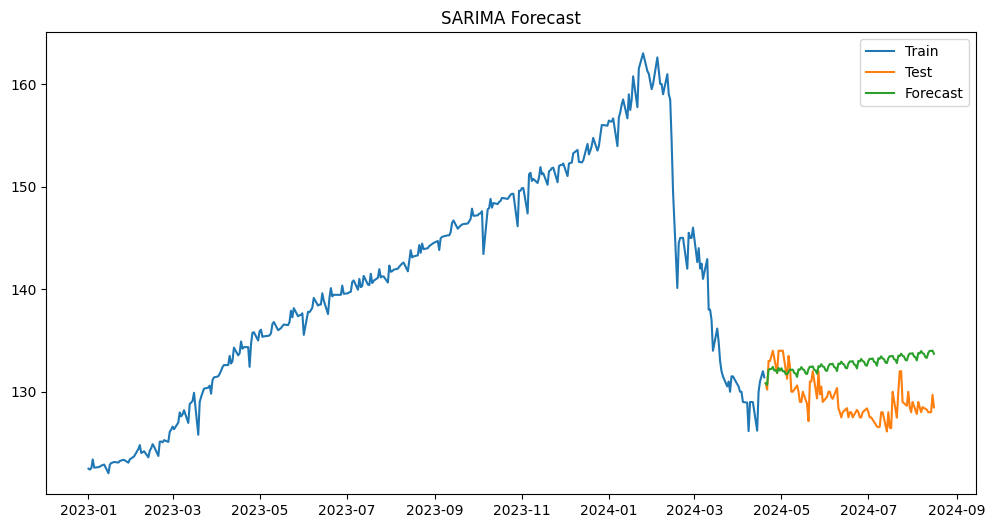

In [48]:
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, predictions2, label='Forecast')
plt.title('SARIMA Forecast')
plt.legend()
plt.show()

## 3. LSTM Model

# Method2

## 1. ARIMA Model

In [104]:
# Function to calculate RMSE
def calculate_rmse(train, predicted):
    return sqrt(mean_squared_error(train, predicted))

In [105]:
# Step 4: ARIMA Model
def fit_arima(train, test):
    model = ARIMA(train, order=(1, 1, 1))
    results = model.fit()
    
    forecast = results.forecast(steps=len(test))
    rmse = calculate_rmse(test['Close'], forecast)
    
    plt.figure(figsize=(12, 6))
    plt.plot(train.index, train, label='Train')
    plt.plot(test.index, test, label='Test')
    plt.plot(test.index, forecast, label='Forecast')
    plt.title('ARIMA Forecast')
    plt.legend()
    plt.show()
    
    print(f'ARIMA RMSE: {rmse}')

Running ARIMA model...


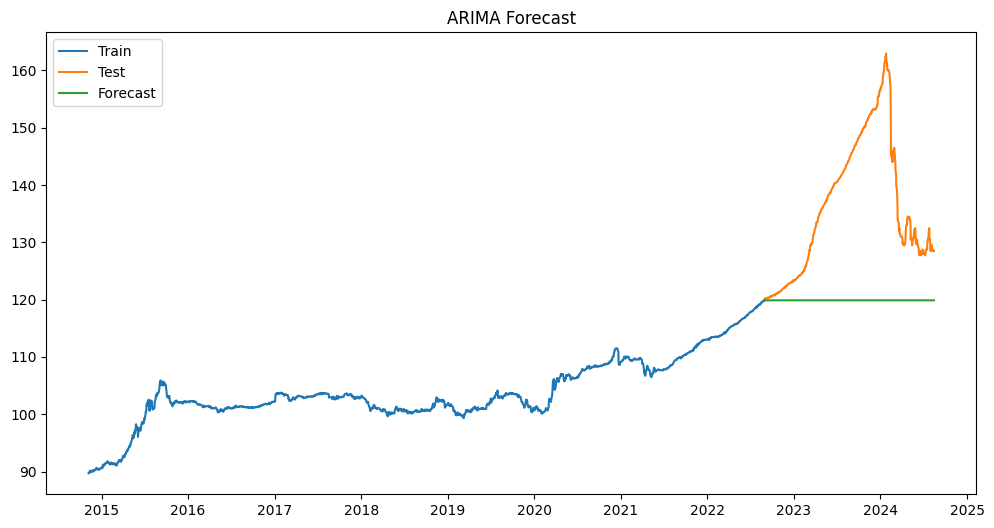

ARIMA RMSE: 19.97887019520599


In [106]:
# Step 7: Run the models
print("Running ARIMA model...")
fit_arima(train, test)

## 2. SARIMA Model

In [46]:

# Step 5: SARIMA Model
def fit_sarima(train, test):
    model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
    results = model.fit()
    
    forecast = results.forecast(steps=len(test))
    rmse = calculate_rmse(test, forecast)
    
    plt.figure(figsize=(12, 6))
    plt.plot(train.index, train, label='Train')
    plt.plot(test.index, test, label='Test')
    plt.plot(test.index, forecast, label='Forecast')
    plt.title('SARIMA Forecast')
    plt.legend()
    plt.show()
    
    print(f'SARIMA RMSE: {rmse}')

Running SARIMA model...


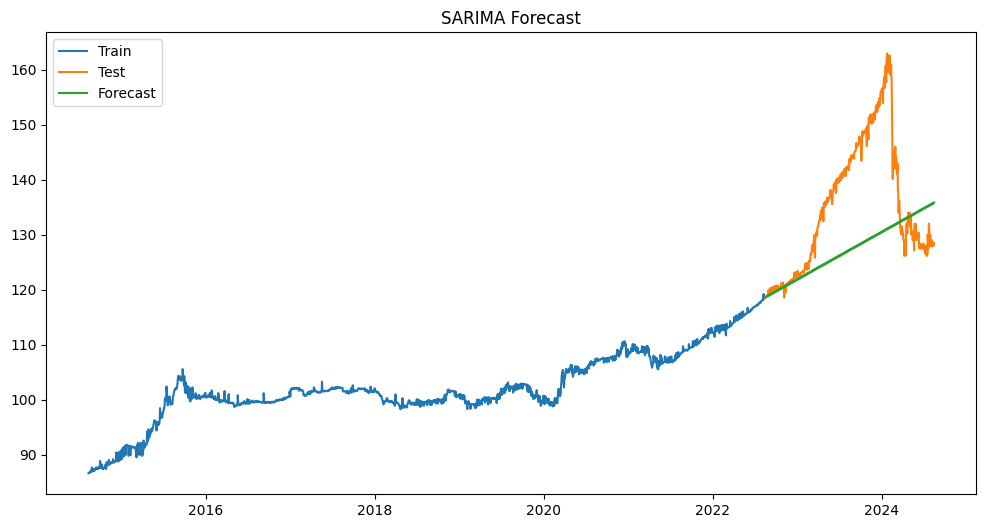

SARIMA RMSE: 12.960068280930932


In [47]:
print("Running SARIMA model...")
fit_sarima(train, test)

## 3. LSTM

# USD TO UGX

In [138]:
# Get the daily exchange rates
df, meta_data = fx.get_currency_exchange_daily(from_symbol="USD", to_symbol="UGX", outputsize="full")

In [139]:
# Renaming columns
df.rename(columns={
    "1. open": "Open",
    "2. high": "High",
    "3. low": "Low",
    "4. close": "Close"
}, inplace=True)

In [140]:
df = df.sort_index()

In [141]:
# df = df.loc['2023':]

In [142]:
df.head()

,Open,High,Low,Close
date,,,,
2014-11-07,2705.0,2705.0,2705.0,2705.0
2014-11-10,2705.0,2705.0,2700.0,2700.0
2014-11-11,2710.0,2710.0,2710.0,2710.0
2014-11-12,2710.0,2730.0,2710.0,2720.0
2014-11-13,2720.0,2745.0,2720.0,2745.0


In [143]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2546 entries, 2014-11-07 to 2024-08-15
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2546 non-null   float64
 1   High    2546 non-null   float64
 2   Low     2546 non-null   float64
 3   Close   2546 non-null   float64
dtypes: float64(4)
memory usage: 99.5 KB


In [144]:
df = df["Close"]
df = pd.DataFrame(data=df)

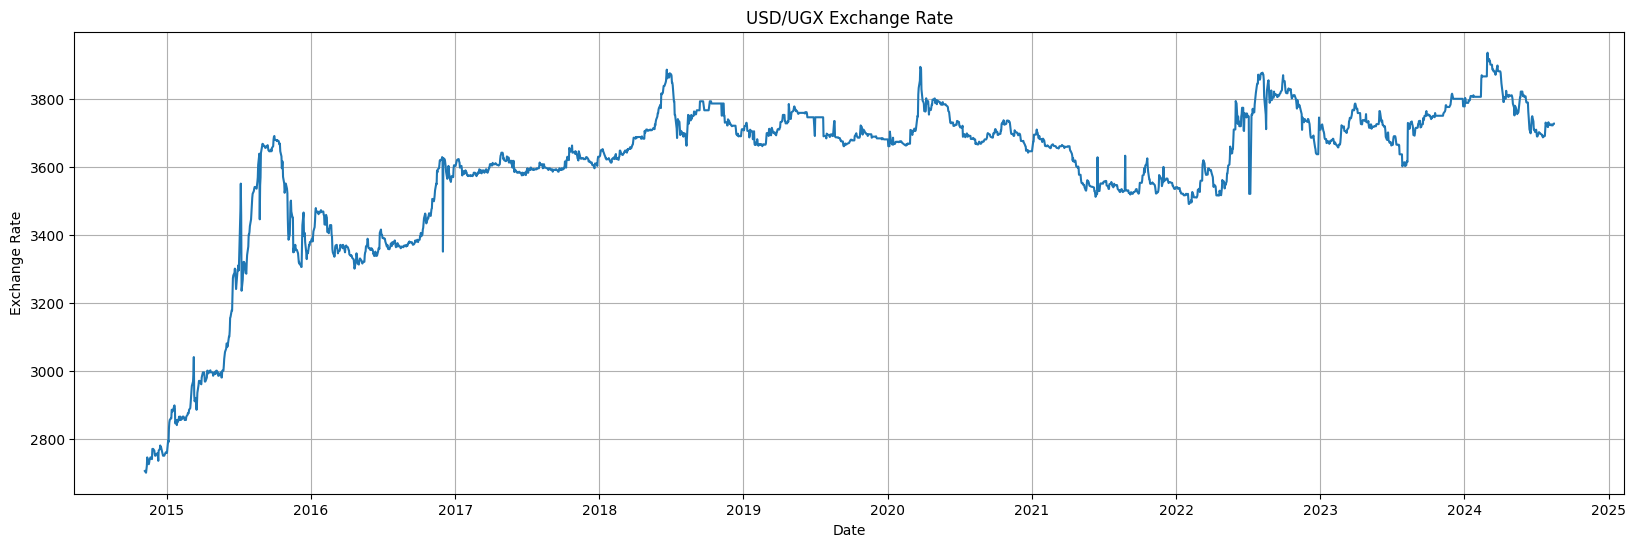

In [145]:
# Plot the data
plt.figure(figsize=(20, 6))
plt.plot(df['Close'])
plt.title('USD/UGX Exchange Rate')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.grid()
plt.show()

In [146]:
# Resample the data to include all the days
daily_df = df.resample('D').last()

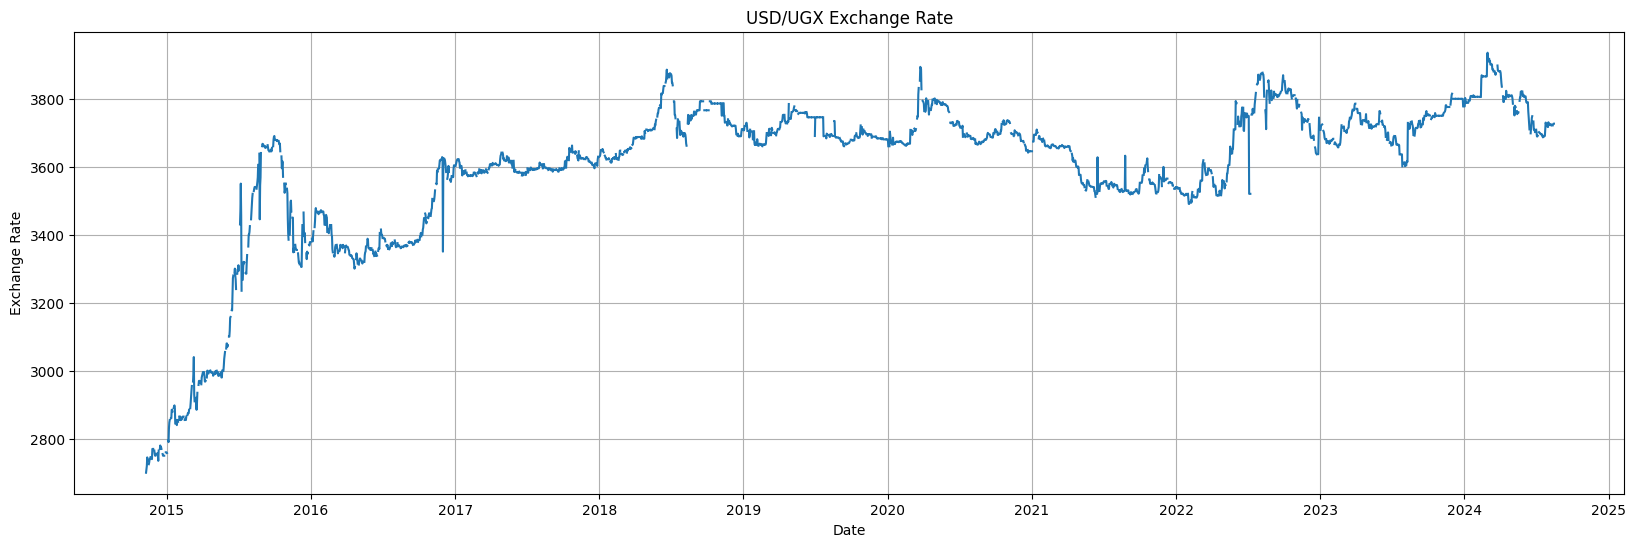

In [147]:
# Plot the data
plt.figure(figsize=(20, 6))
plt.plot(daily_df['Close'])
plt.title('USD/UGX Exchange Rate')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.grid()
plt.show()

In [148]:
# interpolate the data to include weekends
filled_df = daily_df.interpolate(method='linear')

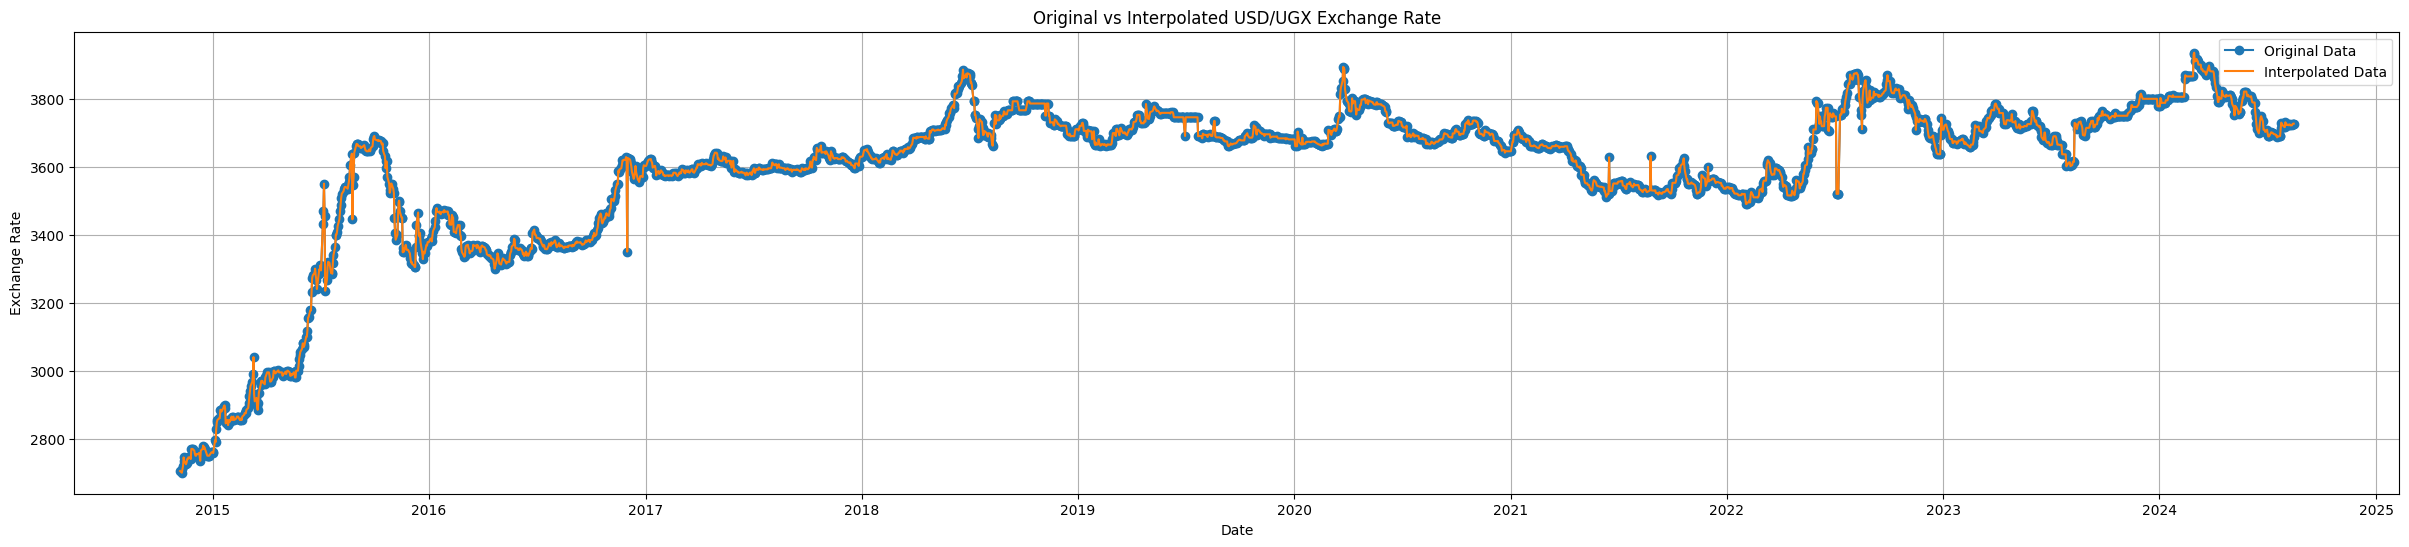

In [149]:
# Plot original vs filled data
plt.figure(figsize=(30, 6))
plt.plot(df.index, df['Close'], label='Original Data', marker='o')
plt.plot(filled_df.index, filled_df['Close'], label='Interpolated Data')
plt.title('Original vs Interpolated USD/UGX Exchange Rate')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.grid()
plt.legend()
plt.show()

In [150]:
from statsmodels.tsa.stattools import adfuller

# Perform the Augmented Dickey-Fuller test
adf_test = adfuller(filled_df['Close'])
print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')

# If p-value > 0.05, the series is non-stationary
if adf_test[1] > 0.05:
    print("The series is non-stationary, differencing is required.")
else:
    print("The series is stationary.")

ADF Statistic: -4.006946216948956
p-value: 0.0013745724068554626
The series is stationary.


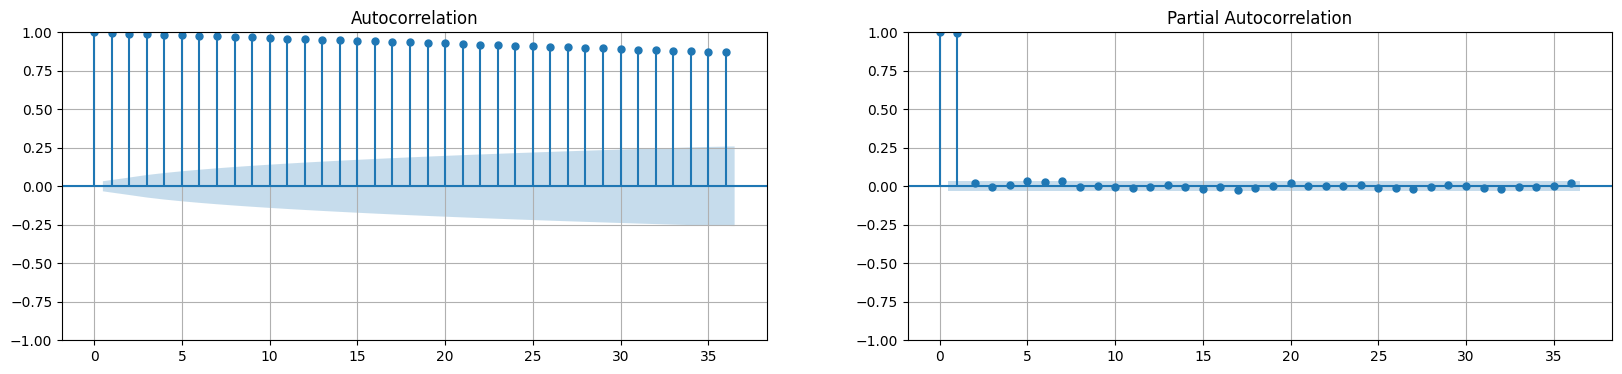

In [151]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(20, 4))
plot_acf(filled_df, ax=axes[0])
axes[0].grid(True)
plot_pacf(filled_df, ax=axes[1])
axes[1].grid(True)
plt.show()

In [152]:
# Split the filled data into train and test sets
train_size2 = int(len(filled_df) * 0.80)
train2, test2 = filled_df[:train_size2], filled_df[train_size2:]

In [153]:
print("Train: ",train2.shape)
print("Test : ",test2.shape)

Train:  (2856, 1)
Test :  (714, 1)


In [154]:
add_decomp2 = seasonal_decompose(train2, model="additive")

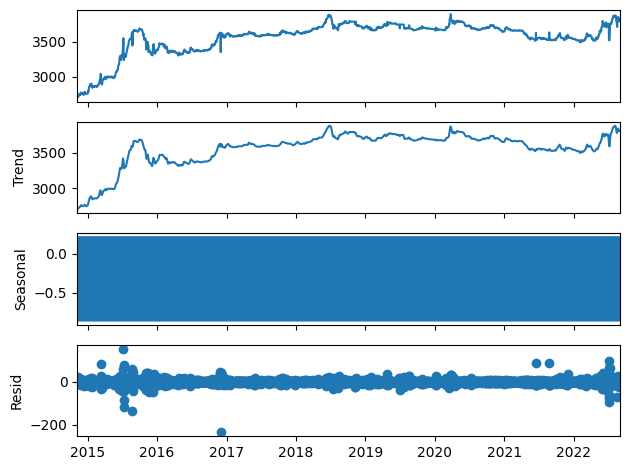

In [155]:
add_decomp2.plot()
plt.show()

In [156]:
import statsmodels.tsa.stattools as sts
adf_results2 = sts.adfuller(train2)
#adf_results

In [157]:
adf_statistic = adf_results[0]
p_value = adf_results[1]
usedlag = adf_results[2]
nobs = adf_results[3]
critical_values = adf_results[4]
icbest = adf_results[5]

print('ADF Statistic:', adf_statistic)
print('p-value:', p_value)
print('Number of Lags Used:', usedlag)
print('Number of Observations Used:', nobs)
print('Critical Values:')
for key, value in critical_values.items():
    print(f'\t{key}: {value}')


ADF Statistic: -0.4589731066692802
p-value: 0.8997770426916989
Number of Lags Used: 18
Number of Observations Used: 2837
Critical Values:
	1%: -3.432657094354157
	5%: -2.862559315261322
	10%: -2.5673126119599647


In [158]:
diff2 = train2.diff().dropna()

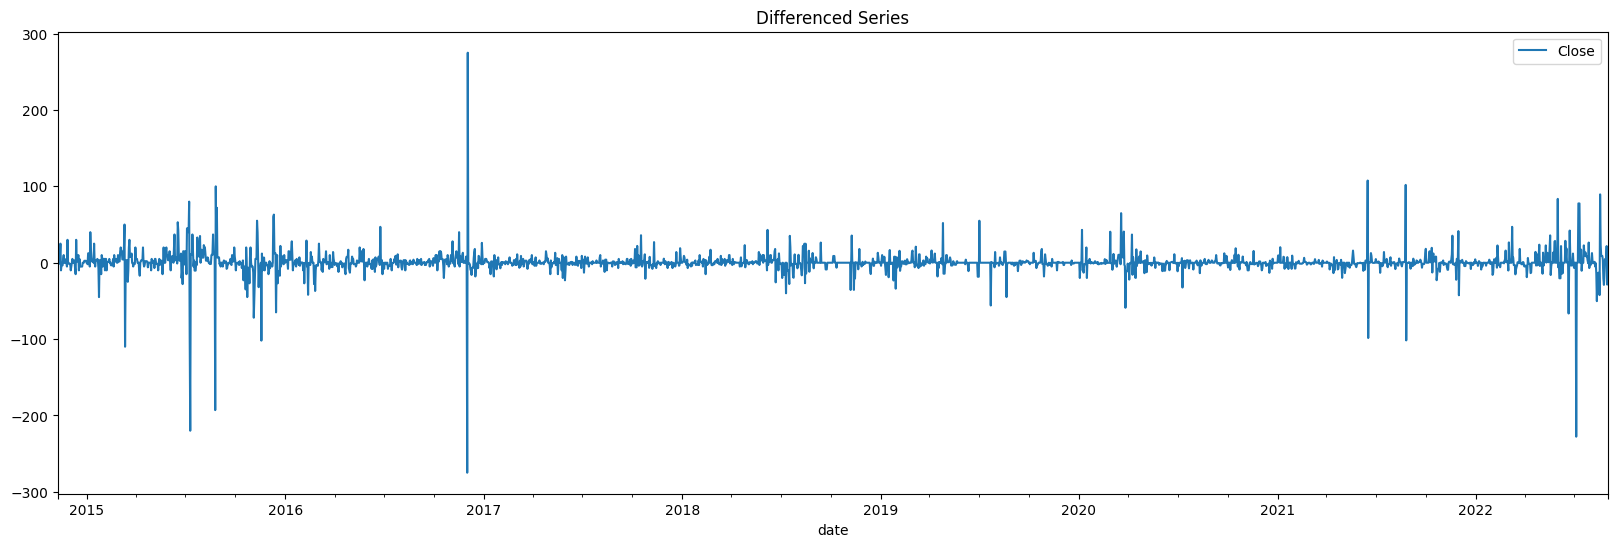

In [159]:
# Plot the differenced series
diff2.plot(figsize=(20, 6))
plt.title('Differenced Series')
plt.show()

In [160]:
# Perform the ADF test on the differenced series
adf_result_diff2 = adfuller(diff2)
print('ADF Statistic after Differencing:', adf_result_diff2[0])
print('p-value after Differencing:', adf_result_diff2[1])
print('Number of Lags Used:', adf_result_diff2[2])
print('Number of Observations Used:', adf_result_diff2[3])
print('Critical Values after Differencing:', adf_result_diff2[4])

ADF Statistic after Differencing: -25.848365286047283
p-value after Differencing: 0.0
Number of Lags Used: 5
Number of Observations Used: 2849
Critical Values after Differencing: {'1%': -3.4326473680863936, '5%': -2.862555019680051, '10%': -2.56731032501228}


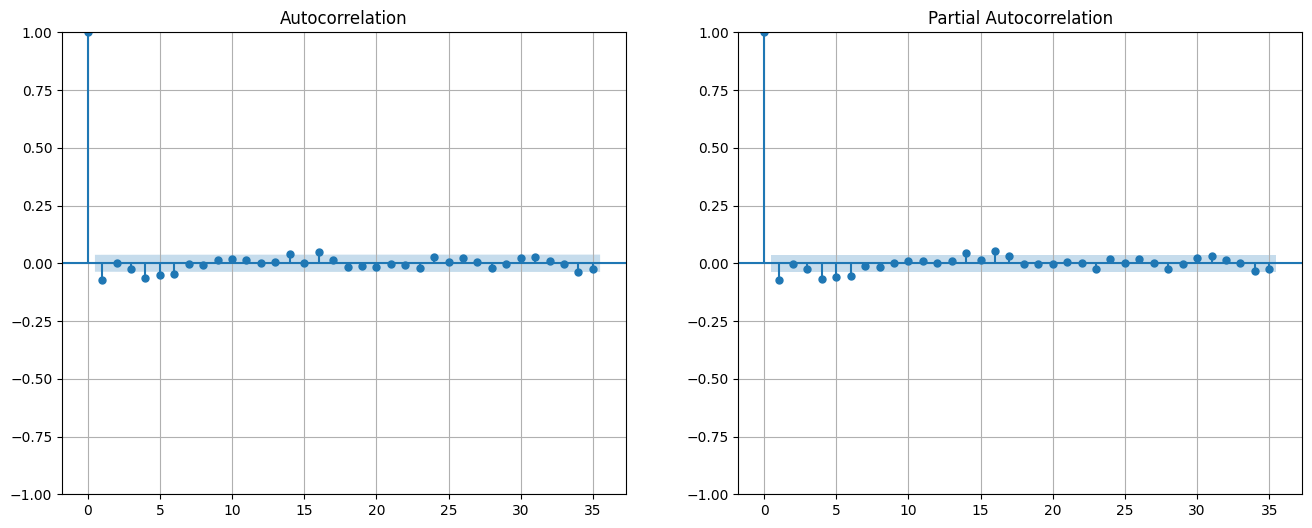

In [161]:
# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(diff2, ax=axes[0])
axes[0].grid(True)
plot_pacf(diff2, ax=axes[1])
axes[1].grid(True)
plt.show()

In [167]:
# Replace p, d, q with the values identified from ACF and PACF
model2 = ARIMA(train2, order=(5, 1, 1))
model_fit2 = model2.fit()

In [168]:
predict = model_fit2.predict(start=len(train2), end=len(train2)+ len(test2)-1, dynamic=True)

In [169]:
predict

2022-09-02    3800.225926
2022-09-03    3799.346998
2022-09-04    3799.626795
2022-09-05    3800.362256
2022-09-06    3800.571941
                 ...     
2024-08-11    3800.710338
2024-08-12    3800.710338
2024-08-13    3800.710338
2024-08-14    3800.710338
2024-08-15    3800.710338
Freq: D, Name: predicted_mean, Length: 714, dtype: float64

In [170]:
# Calculate Mean Squared Error
mse2 = mean_squared_error(test2, predict)
print(f'Mean Squared Error: {mse2}')

Mean Squared Error: 6372.25495104647


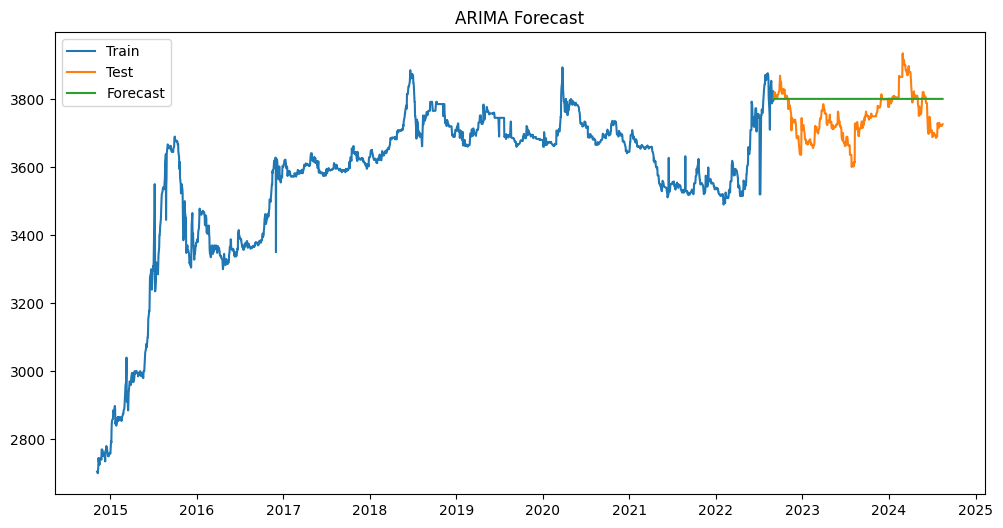

In [171]:
plt.figure(figsize=(12, 6))
plt.plot(train2.index, train2, label='Train')
plt.plot(test2.index, test2, label='Test')
plt.plot(test2.index, predict, label='Forecast')
plt.title('ARIMA Forecast')
plt.legend()
plt.show()

In [172]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model_s2 = SARIMAX(train2, order=(p, d, q), seasonal_order=(p, d, q, 7))  
fitted2 = model_s2.fit() 


In [173]:
# Get the predicted values
predict2 = fitted2.predict(start=len(train2), end=len(train2)+ len(test2)-1, dynamic=True)

In [174]:
predict2

2022-09-02    3802.029834
2022-09-03    3802.842660
2022-09-04    3803.550970
2022-09-05    3804.184272
2022-09-06    3803.847713
                 ...     
2024-08-11    4072.232418
2024-08-12    4072.639906
2024-08-13    4071.980835
2024-08-14    4073.158061
2024-08-15    4073.712864
Freq: D, Name: predicted_mean, Length: 714, dtype: float64

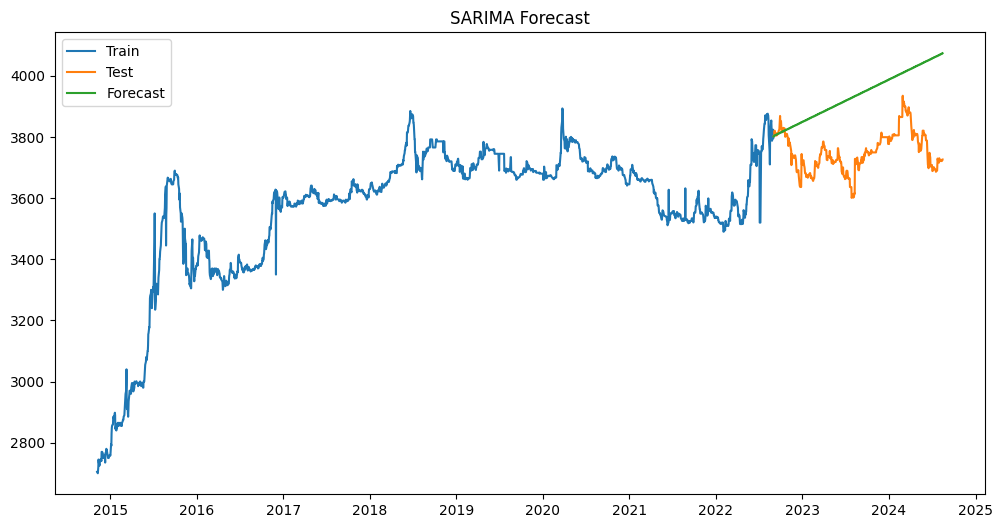

In [175]:
plt.figure(figsize=(12, 6))
plt.plot(train2.index, train2, label='Train')
plt.plot(test2.index, test2, label='Test')
plt.plot(test2.index, predict2, label='Forecast')
plt.title('SARIMA Forecast')
plt.legend()
plt.show()